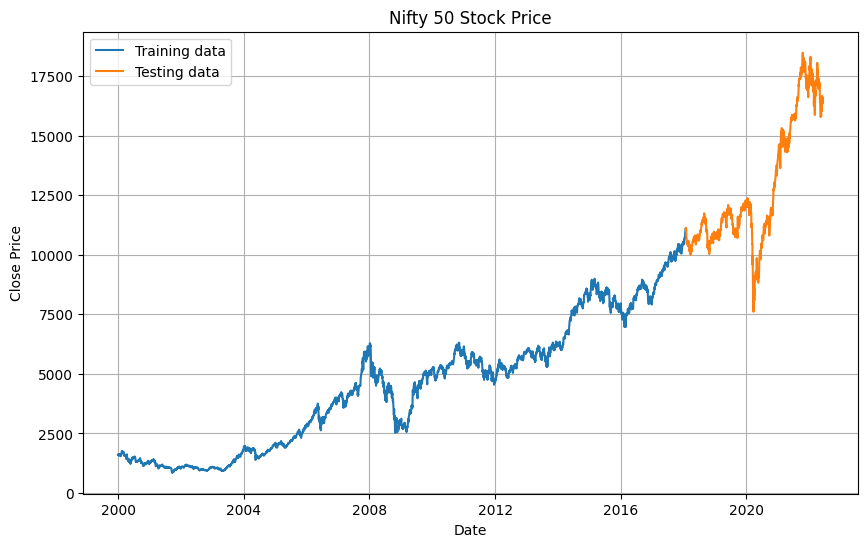

(5582, 2)
(4500, 2)
(1082, 2)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the stock price data from the CSV file
file_path = r'C:\Desktop\Finsearch_23_G12\Stock_data\Nifty_50_2000-2023\Nifty_50_with_indicators_.csv'
data = pd.read_csv(file_path)

# Convert the 'Date' column to a datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date
data = data.sort_values(by='Date')

# Set the index to the datetime values
data = data.set_index(pd.DatetimeIndex(data['Date'].values))

# Keep only the 'Date' and 'close' columns
data = data[['Date', 'close']]

# Drop rows with missing values
data = data.dropna()

#spliting the data into test and train
train_data=data.iloc[:4500]
test_data=data.iloc[4500:]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(train_data['Date'], train_data['close'], label='Training data')
plt.plot(test_data['Date'], test_data['close'], label='Testing data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Nifty 50 Stock Price')
plt.legend()
plt.grid(True)
plt.show()
print(data.shape)
print(train_data.shape)
print(test_data.shape)

In [ ]:
%pip install pandas_ta

In [9]:
import pandas_ta as ta

def calculate_technical_indicators(df):
    # Calculate technical indicators using the historical price data
    data['RSI'] = ta.rsi(data.close, length=15)
    data['EMAF'] = ta.ema(data.close, length=20)
    data['EMAM'] = ta.ema(data.close, length=100)
    data['EMAS'] = ta.ema(data.close, length=150)
    # Add more technical indicators as needed

    return df

def create_state_space(data, window_size=10):
    """
    Create the state space for stock price prediction.

    Parameters:
        data (pd.DataFrame): Historical stock price data with 'Date' and 'Close' columns.
        window_size (int): The number of past data points to consider in the state.

    Returns:
        state_space (np.ndarray): A 2D numpy array representing the state space.
    """
    # Calculate technical indicators
    data = calculate_technical_indicators(data)

    # Drop rows with NaN values (due to calculating technical indicators)
    data.dropna(inplace=True)

    # Normalize the data (optional but recommended for better model convergence)
    data = (data - data.min()) / (data.max() - data.min())

    state_space = []
    num_rows = len(data)

    for i in range(num_rows - window_size):
        state = data.iloc[i:i + window_size].values.flatten()
        state_space.append(state)

    return np.array(state_space)

# Example usage
state_space = create_state_space(train_data, window_size=10)
print(state_space.shape)  # Output: (num_samples, num_features)

C:\Users\Ishan\AppData\Local\Temp\ipykernel_9116\3089114034.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


(4490, 20)


In [10]:
# Define the action space as a list of actions
ACTION_BUY = 0
ACTION_SELL = 1
ACTION_HOLD = 2

def create_action_space():
    """
    Create the action space for stock price prediction.

    Returns:
        action_space (list): A list of possible actions.
    """
    action_space = [ACTION_BUY, ACTION_SELL, ACTION_HOLD]
    return action_space

# Example usage
action_space = create_action_space()
print(action_space)  # Output: [0, 1, 2] representing 'Buy', 'Sell', and 'Hold' actions

[0, 1, 2]


In [11]:
import random
import numpy as np

def create_q_table(state_space, action_space, random_seed=42):
    """
    Create the Q-learning table.

    Parameters:
        state_space (np.ndarray): A 2D numpy array representing the state space.
        action_space (list): A list of possible actions.
        random_seed (int): Seed for the random number generator.

    Returns:
        q_table (np.ndarray): The Q-learning table.
    """
    num_states = len(state_space)
    num_actions = len(action_space)

    np.random.seed(random_seed)
    q_table = np.random.random((num_states, num_actions))

    return q_table


def epsilon_greedy_action(q_table, state, action_space, epsilon):
    """
    Choose an action using epsilon-greedy exploration.

    Parameters:
        q_table (dict): The Q-learning table.
        state (tuple): The current state.
        action_space (list): A list of possible actions.
        epsilon (float): The probability of choosing a random action (exploration rate).

    Returns:
        chosen_action: The chosen action.
    """
    if random.random() < epsilon:
        chosen_action = random.choice(action_space)
    else:
        q_values = q_table[state]
        max_q_value = max(q_values)
        best_actions = [action for action, q_value in enumerate(q_values) if q_value == max_q_value]
        chosen_action = random.choice(best_actions)
    return chosen_action

# Example usage
state_space = create_state_space(train_data, window_size=10)  
action_space = create_action_space()
q_table = create_q_table(state_space, action_space)

# Generate a random state index within the valid range
state_idx = random.randint(0, len(state_space) - 1)

epsilon = 0.2  # Exploration rate (0.2 means 20% of the time explore randomly)
chosen_action = epsilon_greedy_action(q_table, state_idx, action_space, epsilon)
print(chosen_action)


C:\Users\Ishan\AppData\Local\Temp\ipykernel_9116\3089114034.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


1


In [14]:
def get_price_movement_reward(current_price, next_price):
    """
    Define the reward based on the price movement between the current and next time steps.

    Parameters:
        current_price (float): The stock price at the current time step.
        next_price (float): The stock price at the next time step.

    Returns:
        reward (float): The reward for the action.
    """
    price_diff = next_price - current_price

    if price_diff > 0:
        # Positive reward for buying low and selling high
        reward = 1.0
    elif price_diff < 0:
        # Negative reward for buying high and selling low
        reward = -1.0
    else:
        # No reward for holding (price remains the same)
        reward = 0.0

    return reward

In [15]:
def q_learning_update(q_table, state, action, reward, next_state, learning_rate, discount_factor):
    """
    Perform Q-learning update for the given state-action pair.

    Parameters:
        q_table (dict): The Q-learning table.
        state (tuple): The current state.
        action (int): The chosen action.
        reward (float): The reward obtained from the chosen action.
        next_state (tuple): The state resulting from the chosen action.
        learning_rate (float): The learning rate (alpha) to update Q-values.
        discount_factor (float): The discount factor (gamma) for future rewards.

    Returns:
        None (the Q-table is updated in place).
    """
    current_q_value = q_table[state][action]
    max_next_q_value = max(q_table[next_state])
    new_q_value = current_q_value + learning_rate * (reward + discount_factor * max_next_q_value - current_q_value)

    # Update the Q-value for the state-action pair
    q_table[state][action] = new_q_value

In [40]:
def update_state(state, action, data, window_size=10):
    """
    Calculate the next state based on the action taken.

    Parameters:
        state (tuple): The current state.
        action (int): The action taken (e.g., 0 for 'Buy', 1 for 'Sell', 2 for 'Hold').
        data (pd.DataFrame): Historical stock price data with 'Date' and 'Close' columns.
        window_size (int): The number of past data points to consider in the state.

    Returns:
        next_state (tuple): The next state resulting from the action taken.
    """
    # Extract the next_state_idx from the state tuple
    next_state_idx = state[-1]

    # Convert the index to an integer
    next_state_idx = int(next_state_idx)

    if action == 0:  # Buy action
        print("Buy:", next_state_idx + 1, next_state_idx + window_size)
        next_state_data = data.loc[next_state_idx + 1:next_state_idx + window_size, 'close']
    elif action == 1:  # Sell action
        print("Sell:", next_state_idx + 1, next_state_idx + window_size)
        next_state_data = data.loc[next_state_idx + 1:next_state_idx + window_size, 'close']
    else:  # Hold action (do nothing)
        print("Hold:", next_state_idx, next_state_idx + window_size - 1)
        next_state_data = data.loc[next_state_idx:next_state_idx + window_size - 1, 'close']

    # Print the values for further debugging
    print("Next State Data:", next_state_data)

    next_state = tuple(next_state_data.values) + (next_state_idx, )

    return next_state


In [41]:
window_size = 10 

for i in range(len(train_data) - window_size - 1):
    current_price = data['close'].iloc[i]
    next_price = data['close'].iloc[i + 1]

    # Calculate reward using the reward function
    reward = get_price_movement_reward(current_price, next_price)

    # Perform Q-learning updates based on the state, action, reward, and next state
    action = epsilon_greedy_action(q_table, state_idx, action_space, epsilon)
    learning_rate = 0.1  # Learning rate (alpha)
    discount_factor = 0.9  # Discount factor (gamma)
    next_state = update_state(state_space, action, data, window_size)
    
    q_learning_update(q_table, state, action, reward, next_state, learning_rate, discount_factor)

    

TypeError: only size-1 arrays can be converted to Python scalars